Import library

In [ ]:
!pip install livelossplot

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk

In [4]:
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical , plot_model
from sklearn.model_selection import train_test_split

Importing data set

In [5]:
data= pd.read_csv("ner_dataset.csv",encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


Processing data

In [6]:

#Storing unique words and tags as a list
words = list(set(data['Word'].values))
tags = list(set(data['Tag'].values))
# word : ID array and reverse array
token_idx =  {tok:idx+1 for  idx, tok in enumerate(words)}
idx_token =  {idx:tok  for  idx, tok in enumerate(words)}
# tag : ID array and reverse array
tag_idx =  {tok:idx for  idx, tok in enumerate(tags)}
idx_tag =  {idx:tok for  idx, tok in enumerate(tags)}


In [7]:
data['Word_idx'] = data['Word'].map(token_idx)
data['Tag_idx'] = data['Tag'].map(tag_idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,12390,7
1,NaN,of,IN,O,33343,7
2,NaN,demonstrators,NNS,O,11244,7
3,NaN,have,VBP,O,6734,7
4,NaN,marched,VBN,O,15430,7


In [8]:
datafill = data.fillna(method='ffill', axis=0)
data_group = datafill.groupby(['Sentence #'],as_index=False)[['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))
data_group.head()


<ipython-input-8-b491dcdbd70d>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  datafill = data.fillna(method='ffill', axis=0)


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[12390, 33343, 11244, 6734, 15430, 9538, 25473...","[7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 3, 7, 7, ..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[24513, 25906, 1708, 16402, 5912, 22699, 25647...","[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[19218, 19170, 29509, 4427, 4442, 10810, 6050,...","[7, 7, 1, 7, 7, 7, 7, 7, 3, 7, 7, 7, 7, 7, 0, ..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[6959, 23612, 4631, 16713, 28552, 26676, 16703...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[33573, 16235, 33552, 27598, 18883, 8834, 2408...","[3, 7, 7, 12, 14, 7, 1, 7, 3, 7, 6, 7, 6, 7, 7..."


In [9]:
# get len of token and tags
n_token = len(words)
n_tags = len(tags)


In [10]:
#Pad tokens (X var)
token_idx_set = data_group['Word_idx'].tolist()
max_len = max([len(t) for t in token_idx_set])
X = pad_sequences(token_idx_set, maxlen=max_len, dtype='int32', padding='post', value= n_token-1 )

#Pad tokens (Y var)
tag_idx_set = data_group['Tag_idx'].tolist()
Y = pad_sequences(tag_idx_set, maxlen=max_len, dtype='int32', padding='post', value= tag_idx["O"])
Y = [to_categorical(i, num_classes=len(tag_idx)) for i in Y]

In [11]:
# splitting test data and testing data
tok_, test_tokens, tag_, test_tags = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=2000)
train_tokens, value_tokens, train_tags, value_tags = train_test_split(tok_,tag_,test_size = 0.25,train_size =0.75, random_state=2000)


Building LSTM model

In [12]:
np.random.seed(34)
tf.random.set_seed(3)
in_dim = len(list(set(data['Word'].to_list())))+1
out_dim = 64

In [13]:

model = Sequential()
#Embedding layer
model.add(Embedding(input_dim=in_dim, output_dim=out_dim, input_length=max_len))
#bi-LSTM layer
model.add(Bidirectional(LSTM(units=out_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
#LSTM layer
model.add(LSTM(units=out_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
#timeDistributed Layer
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None,max_len))
plot_model(model)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 104, 64)             │       2,251,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 104, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 104, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 104, 17)             │           1,105 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,368,017 (9.03 MB)

 Trainable params: 2,368,017 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

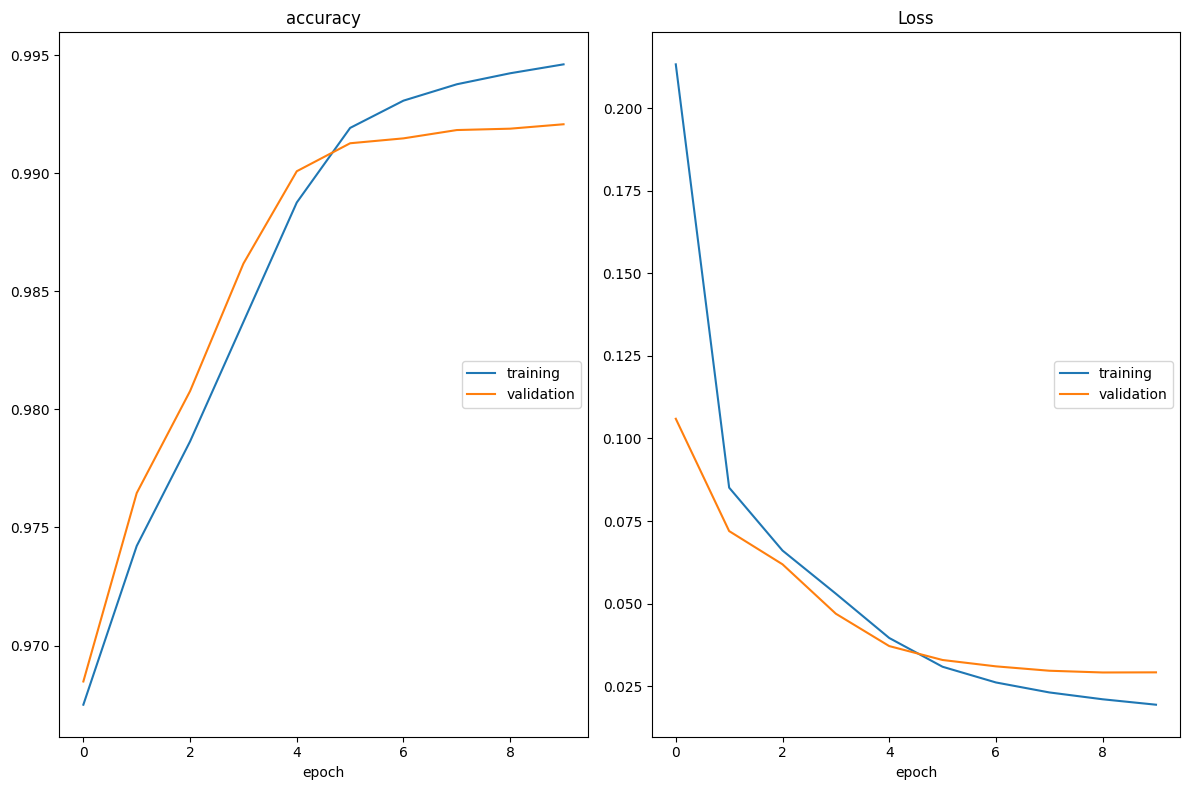

accuracy
	training         	 (min:    0.967, max:    0.995, cur:    0.995)
	validation       	 (min:    0.968, max:    0.992, cur:    0.992)
Loss
	training         	 (min:    0.019, max:    0.213, cur:    0.019)
	validation       	 (min:    0.029, max:    0.106, cur:    0.029)
259/259 ━━━━━━━━━━━━━━━━━━━━ 201s 608ms/step - accuracy: 0.9945 - loss: 0.0197 - val_accuracy: 0.9921 - val_loss: 0.0292


In [15]:
epochs=10
batch=100
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]
hist = model.fit(train_tokens,np.array(train_tags), batch_size=batch, verbose=1, epochs=epochs, validation_split=0.2,callbacks=callbacks)


In [16]:
model.evaluate(test_tokens, np.array(test_tags))


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.9920 - loss: 0.0293


[0.02899729274213314, 0.9920703172683716]

In [21]:
input_test = np.random.randint(0, test_tokens.shape[0])
p = model.predict(np.array([test_tokens[input_test]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(test_tags), axis=-1)[input_test]
print("{:15}{:5}\t {}\n".format("Word","True","Prediction"))
print("-"*30)
for w,true,pred in zip(test_tokens[input_test], y_true, p[0]):
  print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Word           True 	 Prediction

------------------------------
Mr.            B-per	B-per
Talat          I-per	I-per
will           O    	O
replace        O    	O
Rauf           B-per	B-per
Denktash       I-per	I-per
,              O    	O
who            O    	O
has            O    	O
led            O    	O
the            O    	O
Turkish        B-gpe	B-gpe
Cypriot        I-gpe	I-per
community      O    	O
for            O    	O
decades        O    	O
,              O    	O
but            O    	O
did            O    	O
not            O    	O
seek           O    	O
another        O    	O
term           O    	O
.              O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O
tanker         O    	O